In [ ]:
import torch
import torch.nn as nn

class DropPath(nn.Module):
    """Stochastic Depth for ConvNeXt blocks."""
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel-wise attention."""
    def __init__(self, dim, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim // reduction)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(dim // reduction, dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = x.mean(dim=(2, 3))
        y = self.fc1(y)
        y = self.act(y)
        y = self.fc2(y)
        y = self.sigmoid(y).unsqueeze(-1).unsqueeze(-1)
        return x * y

class ConvNeXtBlock(nn.Module):
    """A ConvNeXt block for 1D/2D data with SE attention."""
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-5):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=9, padding=4, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.se = SEBlock(dim)

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.gamma * x
        x = x.permute(0, 3, 1, 2)
        x = self.se(x)
        x = shortcut + self.drop_path(x)
        return x

class ConvNeXt1D(nn.Module):
    """Upgraded ConvNeXt backbone for spectrogram/audio features."""
    def __init__(self,
                 input_channels=1,
                 depths=[5, 5, 15, 5],
                 dims=[128, 256, 512, 1024],
                 drop_path_rate=0.2,
                 layer_scale_init_value=1e-5):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, dims[0], kernel_size=2, stride=2),
            nn.LayerNorm(dims[0])
        )
        self.stages = nn.ModuleList()
        self.downsamples = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(len(depths)):
            blocks = nn.Sequential(
                *[ConvNeXtBlock(dim=dims[i],
                                drop_path=dp_rates[cur + j],
                                layer_scale_init_value=layer_scale_init_value)
                  for j in range(depths[i])]
            )
            self.stages.append(blocks)
            cur += depths[i]
            if i < len(depths) - 1:
                self.downsamples.append(
                    nn.Sequential(
                        nn.LayerNorm(dims[i], eps=1e-6),
                        nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
                    )
                )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        x: (B, 1, F, T) -> input mel-spectrogram, shape: batch x channel x freq x time
        """
        x = self.stem[0](x)
        x = x.permute(0, 2, 3, 1)
        x = self.stem[1](x)
        x = x.permute(0, 3, 1, 2)
        for i in range(len(self.stages)):
            x = self.stages[i](x)
            if i < len(self.downsamples):
                x = x.permute(0, 2, 3, 1)
                x = self.downsamples[i][0](x)
                x = x.permute(0, 3, 1, 2)
                x = self.downsamples[i][1](x)
        return x


In [ ]:
class SelfAttentivePooling(nn.Module):
    def __init__(self, input_dim, attention_dim=512, num_heads=8, dropout_rate=0.1):
        super().__init__()
        self.attention_dim = attention_dim
        self.num_heads = num_heads
        self.head_dim = attention_dim // num_heads
        self.dropout_rate = dropout_rate

        self.query = nn.Linear(input_dim, attention_dim)
        self.key = nn.Linear(input_dim, attention_dim)
        self.value = nn.Linear(input_dim, attention_dim)

        self.attn_dropout = nn.Dropout(dropout_rate)
        self.out_proj = nn.Linear(attention_dim, attention_dim)
        self.out_dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(attention_dim)
        self.input_proj = nn.Linear(input_dim, attention_dim)

    def forward(self, x):
        batch_size, channels, freq, time = x.shape
        x_reshaped = x.permute(0, 2, 3, 1).contiguous().view(batch_size, freq * time, channels)

        Q = self.query(x_reshaped)
        K = self.key(x_reshaped)
        V = self.value(x_reshaped)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.attn_dropout(attention_weights)

        attended = torch.matmul(attention_weights, V)
        attended = attended.transpose(1, 2).contiguous().view(batch_size, -1, self.attention_dim)

        out = self.out_proj(attended)
        out = self.out_dropout(out)

        x_proj = self.input_proj(x_reshaped)
        out = self.layer_norm(out + x_proj)

        pooled = out.mean(dim=1)
        return pooled

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GraphGuidedConvNet(nn.Module):
    """
    Upgraded Graph Guided Convolution Network (GGCN) with residual connections,
    layer normalization, and GELU activations for improved feature relational modeling.
    """

    def __init__(self, input_dim, hidden_dim=256, num_layers=3, dropout=0.3, k=8):

        super().__init__()
        self.k = k
        self.gcn_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)

        self.gcn_layers.append(GCNConv(input_dim, hidden_dim))
        self.norms.append(nn.LayerNorm(hidden_dim))

        for _ in range(num_layers - 1):
            self.gcn_layers.append(GCNConv(hidden_dim, hidden_dim))
            self.norms.append(nn.LayerNorm(hidden_dim))

    def create_knn_graph(self, x):

        with torch.no_grad():
            num_nodes = x.size(0)
            k = min(self.k, num_nodes - 1)
            dist = torch.cdist(x, x, p=2)
            knn_indices = dist.topk(k=k + 1, largest=False).indices[:, 1:]

            source_nodes = torch.arange(num_nodes, device=x.device).unsqueeze(1).repeat(1, k).flatten()
            target_nodes = knn_indices.flatten().to(x.device)

            edge_index = torch.stack([source_nodes, target_nodes], dim=0)

        return edge_index

    def forward(self, x):


        edge_index = self.create_knn_graph(x)
        residual = None

        for i, (gcn, norm) in enumerate(zip(self.gcn_layers, self.norms)):
            x_in = x
            x = gcn(x, edge_index)
            x = norm(x)
            x = F.gelu(x)
            x = self.dropout(x)
            if i > 0:
                x = x + x_in

        batch_vec = torch.arange(x.size(0), device=x.device)
        x = global_mean_pool(x, batch_vec)

        return x

In [ ]:
class MLPClassifier(nn.Module):
    """
    Multi-Layer Perceptron classifier with dropout for binary deepfake detection.
    """

    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout_rate=0.3, num_classes=2):

        super().__init__()

        layers = []
        last_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim

        layers.append(nn.Linear(last_dim, num_classes))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):

        logits = self.mlp(x)
        return logits

In [ ]:
class DeepFakeDetectionModel(nn.Module):
    def __init__(self,
                 convnext_params,
                 attention_params,
                 ggcn_params,
                 mlp_params):
        super().__init__()

        self.convnext = ConvNeXt1D(**convnext_params)

        self.att_pool = SelfAttentivePooling(**attention_params)

        self.ggcn = GraphGuidedConvNet(**ggcn_params)

        self.mlp = MLPClassifier(**mlp_params)

    def forward(self, x):

        features = self.convnext(x)


        pooled_features = self.att_pool(features)


        graph_features = self.ggcn(pooled_features)

        logits = self.mlp(graph_features)

        return logits

In [ ]:
convnext_params = {
    'input_channels': 1,
    'depths': [3, 3, 9, 3],
    'dims': [96, 192, 384, 768],
    'drop_path_rate': 0.1,
    'layer_scale_init_value': 1e-6
}

attention_params = {
    'input_dim': 768,
    'attention_dim': 512,
    'num_heads': 8
}

ggcn_params = {
    'input_dim': 512,
    'hidden_dim': 256,
    'num_layers': 2,
    'dropout': 0.2,
    'k': 5
}

mlp_params = {
    'input_dim': 256,
    'hidden_dims': [512, 256, 128],
    'dropout_rate': 0.3,
    'num_classes': 2
}

model = DeepFakeDetectionModel(convnext_params, attention_params, ggcn_params, mlp_params)
x = torch.randn(4, 1, 64, 250)
logits = model(x)

In [ ]:
def parse_asvspoof2019_full_metadata(file_paths):
    """
    Parses ASVspoof2019 metadata from multiple protocol/trial files (train, dev, eval).

    Args:
        file_paths (list of str): Paths to metadata text files for all subsets.

    Returns:
        dict: Mapping from utterance ID (str) to dict with keys:
            - 'speaker_id' (str)
            - 'label' (str) : 'spoof' or 'bonafide'
            - 'subset' (str) : 'train', 'dev', or 'eval'
    """
    metadata = {}
    for file_path in file_paths:
        if 'train' in file_path.lower():
            subset_name = 'train'
        elif 'dev' in file_path.lower():
            subset_name = 'dev'
        elif 'eval' in file_path.lower():
            subset_name = 'eval'
        else:
            subset_name = 'unknown'
        
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                speaker_id = parts[0]
                utt_id = parts[1]
                label = parts[4]
                if label not in ('spoof', 'bonafide'):
                    continue
                metadata[utt_id] = {
                    'speaker_id': speaker_id,
                    'label': label,
                    'subset': subset_name
                }
    return metadata

In [ ]:
import numpy as np
import librosa

class MelSpectrogramTransform:
    def __init__(self,
                 sample_rate=16000,
                 n_fft=512,
                 hop_length=160,
                 win_length=400,
                 n_mels=64,
                 fmin=20,
                 fmax=8000,
                 power=2.0,
                 eps=1e-6):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        self.power = power
        self.eps = eps

    def __call__(self, waveform):
        waveform_np = waveform.squeeze(0).numpy()

        mel_spec = librosa.feature.melspectrogram(
            y=waveform_np,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels,
            power=self.power,
            fmin=self.fmin,
            fmax=self.fmax
        )

        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        normalized = (log_mel_spec - np.mean(log_mel_spec)) / (np.std(log_mel_spec) + self.eps)

        tensor = torch.tensor(normalized).unsqueeze(0).float()

        return tensor

In [ ]:
def pad_truncate_collate(batch, max_length=250):

    waveforms = []
    labels = []
    utt_ids = []

    for waveform, label, utt_id in batch:
        time_dim = waveform.shape[-1]
        
        if time_dim > max_length:
            waveform = waveform[..., :max_length]
        elif time_dim < max_length:
            pad_amount = max_length - time_dim
            waveform = F.pad(waveform, (0, pad_amount))

        waveforms.append(waveform)
        labels.append(label)
        utt_ids.append(utt_id)

    batch_waveforms = torch.stack(waveforms)
    labels = torch.tensor(labels)

    return batch_waveforms, labels, utt_ids

In [ ]:
import zipfile
import io
from torch.utils.data import Dataset, DataLoader

def parse_asvspoof2019_trial_metadata_from_lines(lines):
    metadata = {}
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        speaker_id = parts[0]
        utt_id = parts[1]
        label = parts[4]
        if label not in ('spoof', 'bonafide'):
            continue
        metadata[utt_id] = {
            'speaker_id': speaker_id,
            'label': label
        }
    return metadata

class ASVspoof2019ZipDataset(Dataset):
    def __init__(self, zip_path, metadata, subset='LA/LA/ASVspoof2019_LA_train', transform=None):
        self.zip_path = zip_path
        self.metadata = metadata
        self.subset = subset
        self.transform = transform
        self.zip_file = zipfile.ZipFile(zip_path, 'r')
        self.utt_ids = list(metadata.keys())

    def __len__(self):
        return len(self.utt_ids)

    def __getitem__(self, idx):
        utt_id = self.utt_ids[idx]
        label_str = self.metadata[utt_id]['label']
        label = 1 if label_str == 'spoof' else 0

        internal_path = f'{self.subset}/flac/{utt_id}.flac'

        audio_bytes = self.zip_file.read(internal_path)
        audio_buffer = io.BytesIO(audio_bytes)
        waveform_np, sr = sf.read(audio_buffer)
        if waveform_np.ndim > 1:
            waveform_np = np.mean(waveform_np, axis=1)

        waveform = torch.from_numpy(waveform_np).float().unsqueeze(0)
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label, utt_id

    def __del__(self):
        if hasattr(self, 'zip_file'):
            self.zip_file.close()

zip_path = r'C:\Users\HazCodes\Documents\Datasets\ASVspoof2019.zip'
metadata_internal_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

with zipfile.ZipFile(zip_path, 'r') as zf:
    with zf.open(metadata_internal_path) as meta_file:
        trial_lines = meta_file.read().decode('utf-8').splitlines()

metadata = parse_asvspoof2019_trial_metadata_from_lines(trial_lines)
transform = MelSpectrogramTransform()

subset = 'LA/LA/ASVspoof2019_LA_train'
dataset = ASVspoof2019ZipDataset(zip_path, metadata, subset=subset, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=pad_truncate_collate)

In [ ]:
import time
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_model.pth'):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        train_loader_tqdm = tqdm(train_loader, desc="Training")

        for inputs, labels, _ in train_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

            train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=running_corrects/total_samples)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0
        val_loader_tqdm = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for inputs, labels, _ in val_loader_tqdm:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                val_corrects += (preds == labels).sum().item()
                val_samples += labels.size(0)

                val_loader_tqdm.set_postfix(loss=loss.item(), accuracy=val_corrects/val_samples)

        val_epoch_loss = val_loss / val_samples
        val_epoch_acc = val_corrects / val_samples

        scheduler.step()

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} finished in {epoch_duration:.2f} seconds")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model with accuracy: {best_val_acc:.4f}")

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

    return model, history

In [ ]:
import torch.optim as optim

train_metadata_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
dev_metadata_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 20

def lr_lambda(current_epoch):
    warmup_epochs = 3
    if current_epoch < warmup_epochs:
        return float(current_epoch + 1) / warmup_epochs
    else:
        progress = (current_epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

model.to(device)

def parse_asvspoof2019_trial_metadata_from_lines(lines):
    metadata = {}
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        speaker_id = parts[0]
        utt_id = parts[1]
        label = parts[4]
        if label not in ('spoof', 'bonafide'):
            continue
        metadata[utt_id] = {'speaker_id': speaker_id, 'label': label}
    return metadata

with zipfile.ZipFile(zip_path, 'r') as zf:
    with zf.open(train_metadata_path) as f:
        train_lines = f.read().decode('utf-8').splitlines()
    with zf.open(dev_metadata_path) as f:
        dev_lines = f.read().decode('utf-8').splitlines()

train_metadata = parse_asvspoof2019_trial_metadata_from_lines(train_lines)
val_metadata = parse_asvspoof2019_trial_metadata_from_lines(dev_lines)

train_dataset = ASVspoof2019ZipDataset(zip_path, train_metadata, subset='LA/LA/ASVspoof2019_LA_train', transform=transform)
val_dataset = ASVspoof2019ZipDataset(zip_path, val_metadata, subset='LA/LA/ASVspoof2019_LA_dev', transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=True,
    collate_fn=pad_truncate_collate,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=20,
    shuffle=False,
    collate_fn=pad_truncate_collate,
    pin_memory=True
)

trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    save_path='model.pth'
)

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

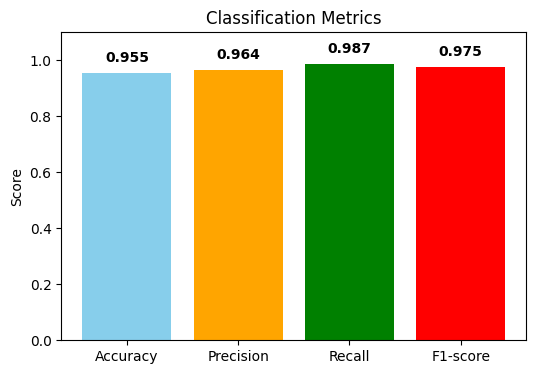

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

def plot_classification_metrics(targets, preds, average='binary'):
    """
    Computes and plots accuracy, precision, recall, and F1-score (no print statements).
    Ensures labels never overlap or clip the border.
    """
    metrics_dict = {
        'Accuracy': accuracy_score(targets, preds),
        'Precision': precision_score(targets, preds, average=average),
        'Recall': recall_score(targets, preds, average=average),
        'F1-score': f1_score(targets, preds, average=average)
    }
    plt.figure(figsize=(6, 4))
    plt.bar(metrics_dict.keys(), metrics_dict.values(), color=['skyblue', 'orange', 'green', 'red'])
    max_value = max(metrics_dict.values())
    plt.ylim(0, max(1.10, max_value + 0.06))
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    for i, (metric, value) in enumerate(metrics_dict.items()):
        plt.text(i, value + 0.04, f"{value:.3f}", ha='center', fontweight='bold')
    plt.show()
    return metrics_dict

plot_classification_metrics(all_targets, all_preds, average='binary')

display(HTML("<style>.jp-InputPrompt, .jp-OutputPrompt { display: none; }</style>"))


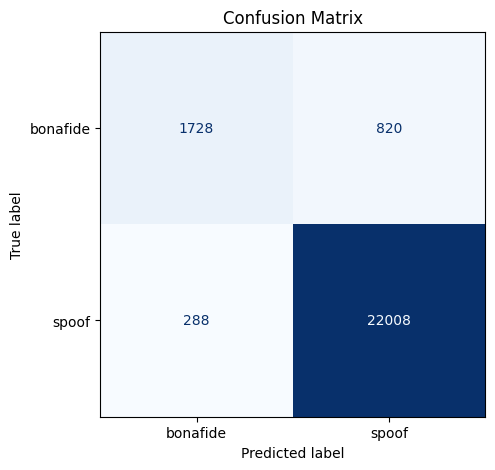

array([[ 1728,   820],
       [  288, 22008]])

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(targets, preds, labels=("bonafide", "spoof")):
    """
    Plots the confusion matrix for classification.

    Args:
        targets: Ground-truth label array or list
        preds: Predicted label array or list
        labels: Class labels, e.g., ('bonafide', 'spoof') or (0, 1)
    """
    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    plt.title('Confusion Matrix')
    plt.show()
    return cm

plot_confusion_matrix(all_targets, all_preds, labels=("bonafide", "spoof"))

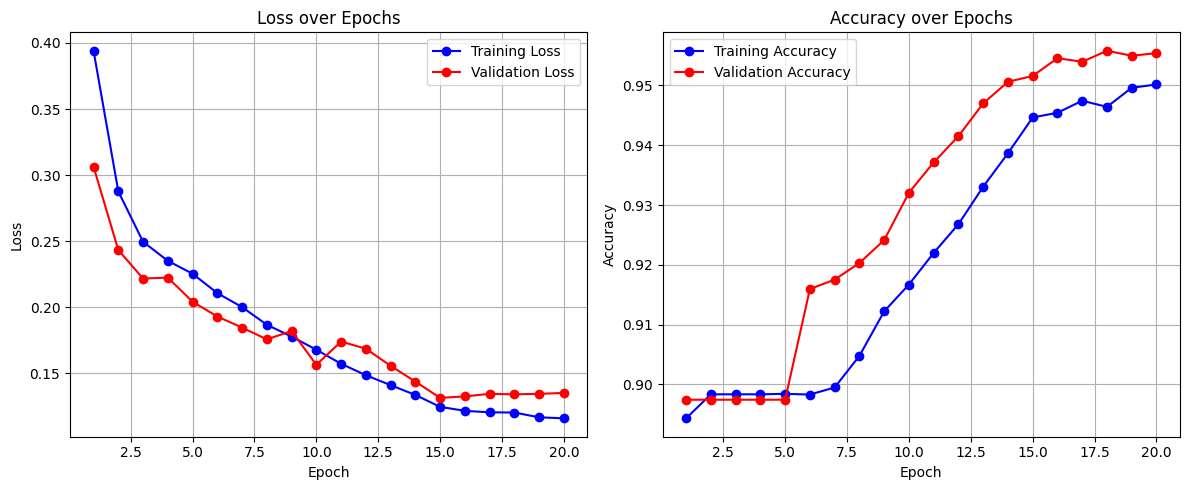

In [25]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)